# Check the impact of using U10x, U10y instead of UBOT, VBOT for CESM2 atmospheric forcing

Mainly interested in the impact on: sea ice area/concentration, surface and intermediate water column temperatures

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
import cmocean
sys.path.append('/home/users/birgal/')
from nemo_python_git.utils import fix_lon_range

Instead of using UBOT, VBOT for wind direction and U10 for wind speed, change the height of the wind in the parameterization? I don't think that's actually reasonable either, because that just means they scale the temperature to that height

But sea level pressure around Antarctica is actually lower than 992 hPa, so the wind is being underestimated?

Lowest atmospheric model level grid cell is not actually the same as the 10 m wind level (closer to 50-100 m; 992 hPa). What did Paul + Kaitlin and Kat do for their model runs? One option would be:
- Use U10 variable for wind speed magnitude and UBOT, VBOT for wind speed direction

$ U_{10}^2 = U_x^2 + U_y^2$

$ U_x = U_{10} \cdot \cos(\theta) $

$ U_y = U_{10} \cdot \sin(\theta) $

$\theta = \tan^{-1}(\frac{U_{BOTy}}{U_{BOTx}})$

## visualize difference in wind strength between shifted winds and bottom winds

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/raw/'

In [11]:
kwags1 = {'lat':slice(-90,-50)}
kwags2 = {'time':slice(0,365)}
land = xr.open_dataset(f'{base_dir}raw/b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h0.LANDFRAC.185001-185912.nc').sel(**kwags1)
bottomu  = xr.open_dataset(f'{base_dir}raw/b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h1.UBOT.18500101-18591231.nc').sel(**kwags1).isel(**kwags2)
bottomv  = xr.open_dataset(f'{base_dir}raw/b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h1.VBOT.18500101-18591231.nc').sel(**kwags1).isel(**kwags2)
original = xr.open_dataset(f'{base_dir}raw/b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h1.U10.18500101-18591231.nc').sel(**kwags1).isel(**kwags2)

In [16]:
speed      = np.sqrt(bottomu.UBOT**2 + bottomv.VBOT**2).mean(dim='time').where(land.LANDFRAC.isel(time=0)==0)
orig_speed = original.U10.mean(dim='time').where(land.LANDFRAC.isel(time=0)==0)

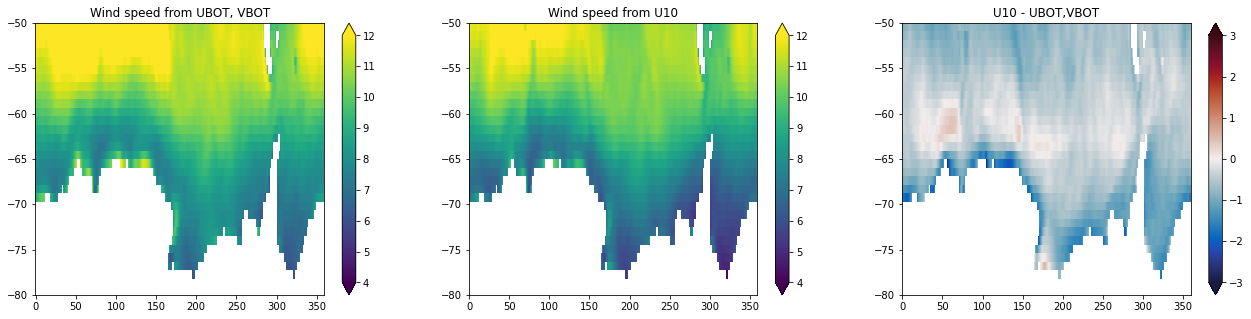

In [23]:
fig, ax = plt.subplots(1,3, figsize=(22,5))
ax[0].set_title('Wind speed from UBOT, VBOT')
ax[1].set_title('Wind speed from U10')
ax[2].set_title('U10 - UBOT,VBOT')
cm1 = ax[0].pcolormesh(speed.lon, speed.lat, speed, vmin=4, vmax=12)
cm2 = ax[1].pcolormesh(original.lon, original.lat, orig_speed, vmin=4, vmax=12)
cm3 = ax[2].pcolormesh(speed.lon, speed.lat, (orig_speed - speed), vmin=-3, vmax=3, cmap=cmocean.cm.balance)
for axis in ax.ravel():
    axis.set_ylim(-80,-50)
fig.colorbar(cm1, ax=ax[0], extend='both')
fig.colorbar(cm2, ax=ax[1], extend='both')
fig.colorbar(cm3, ax=ax[2], extend='both')

## calcs

In [3]:
run_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/CESM2-LE2_ens1011.001/'

In [3]:
dsT_U10  = xr.open_dataset(f'{run_dir}files_u10_shifted/eANT025.L121_1m_18500101_18501231_grid_T.nc')
dsI_U10  = xr.open_dataset(f'{run_dir}files_u10_shifted/eANT025.L121_1m_18500101_18501231_icemod.nc')

dsT_UBOT = xr.open_dataset(f'{run_dir}files_u10_not_shifted/eANT025.L121_1m_18500101_18501231_grid_T.nc')
dsI_UBOT = xr.open_dataset(f'{run_dir}files_u10_not_shifted/eANT025.L121_1m_18500101_18501231_icemod.nc')

In [26]:
# have a quick look at piControl experiment
PI_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/CESM2-piControl/'
dsT_PI = xr.open_dataset(f'{PI_dir}files/eANT025.L121_1m_18500101_18501231_grid_T.nc')
dsI_PI = xr.open_dataset(f'{PI_dir}files/eANT025.L121_1m_18500101_18501231_icemod.nc')

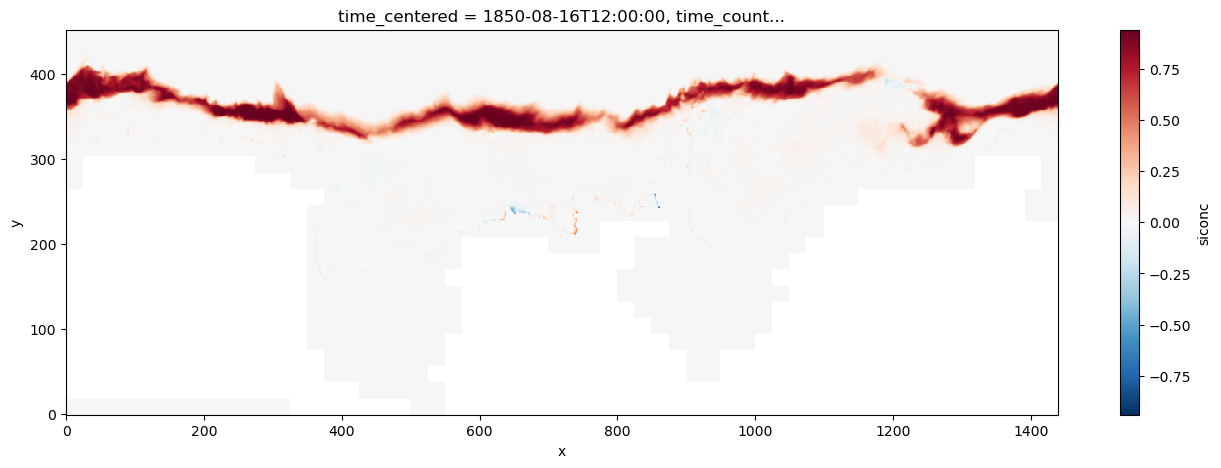

In [29]:
var = 'siconc'
(dsI_U10[var].isel(time_counter=7) - dsI_PI[var].isel(time_counter=7)).plot(figsize=(16,5))

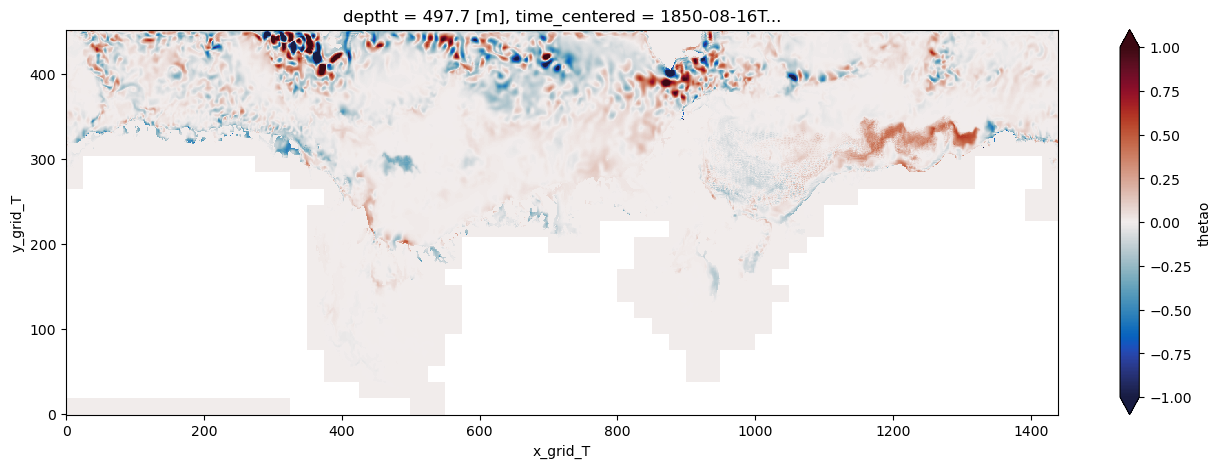

In [32]:
var = 'thetao'
zind=50
(dsT_U10[var].isel(time_counter=7, deptht=zind) - dsT_PI[var].isel(time_counter=7, deptht=zind)).plot(figsize=(16,5),
                                                                                                        vmin=-1, vmax=1,
                                                                                                        cmap=cmocean.cm.balance)

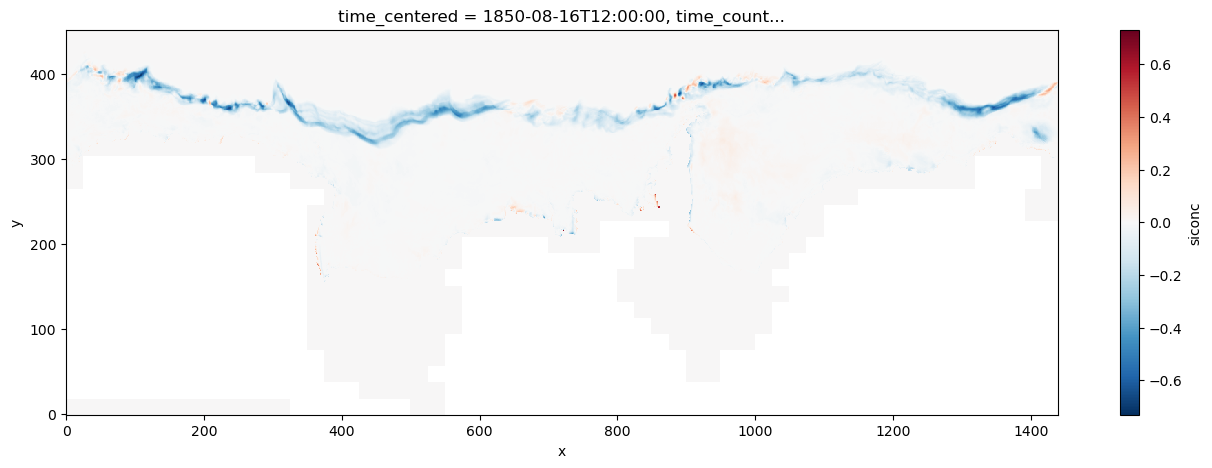

In [15]:
var = 'siconc'
(dsI_UBOT[var].isel(time_counter=7) - dsI_U10[var].isel(time_counter=7)).plot(figsize=(16,5))

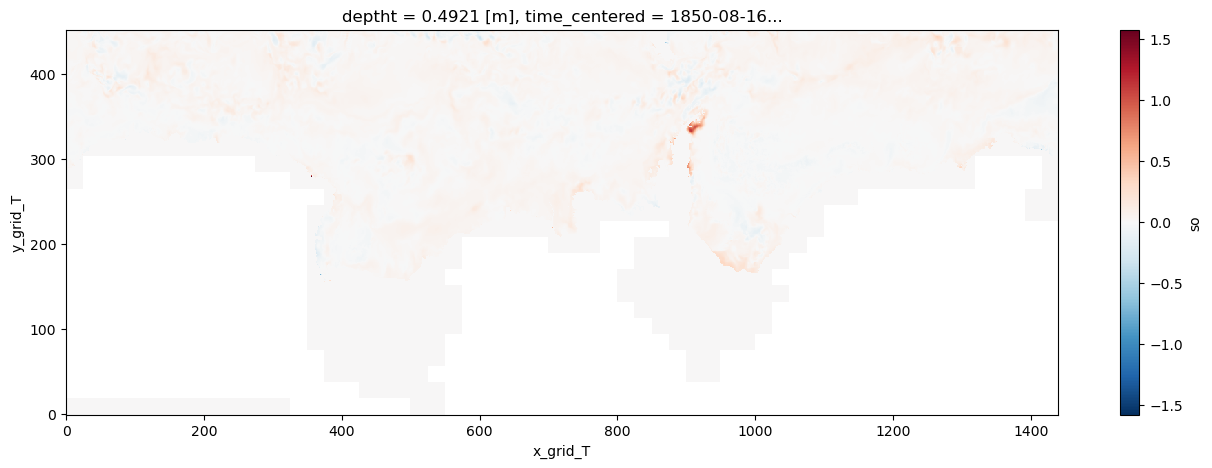

In [16]:
var = 'so'
zind=0
(dsT_UBOT[var].isel(time_counter=7, deptht=zind) - dsT_U10[var].isel(time_counter=7, deptht=zind)).plot(figsize=(16,5))

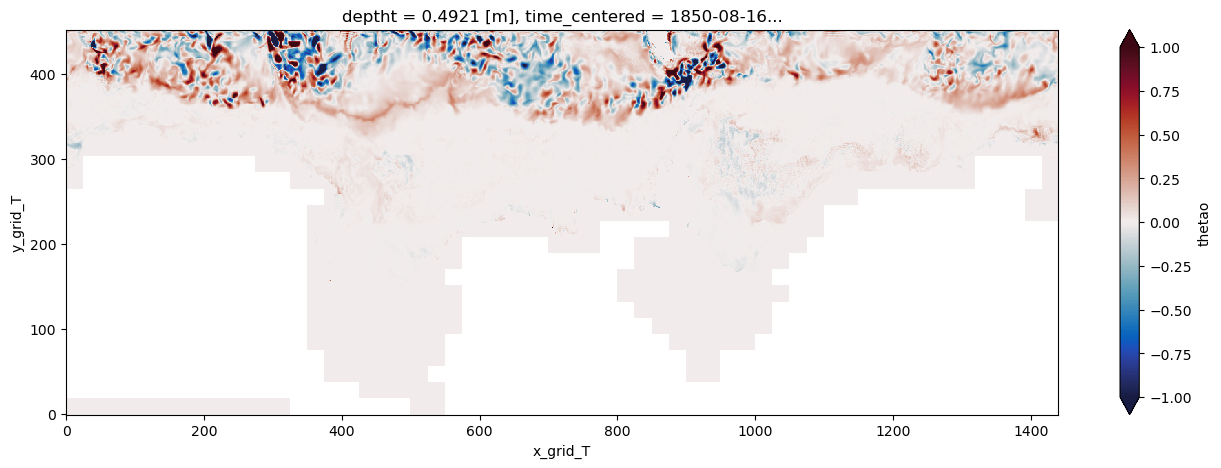

In [24]:
var = 'thetao'
zind=0
(dsT_UBOT[var].isel(time_counter=7, deptht=zind) - dsT_U10[var].isel(time_counter=7, deptht=zind)).plot(figsize=(16,5),
                                                                                                        vmin=-1, vmax=1,
                                                                                                        cmap=cmocean.cm.balance)

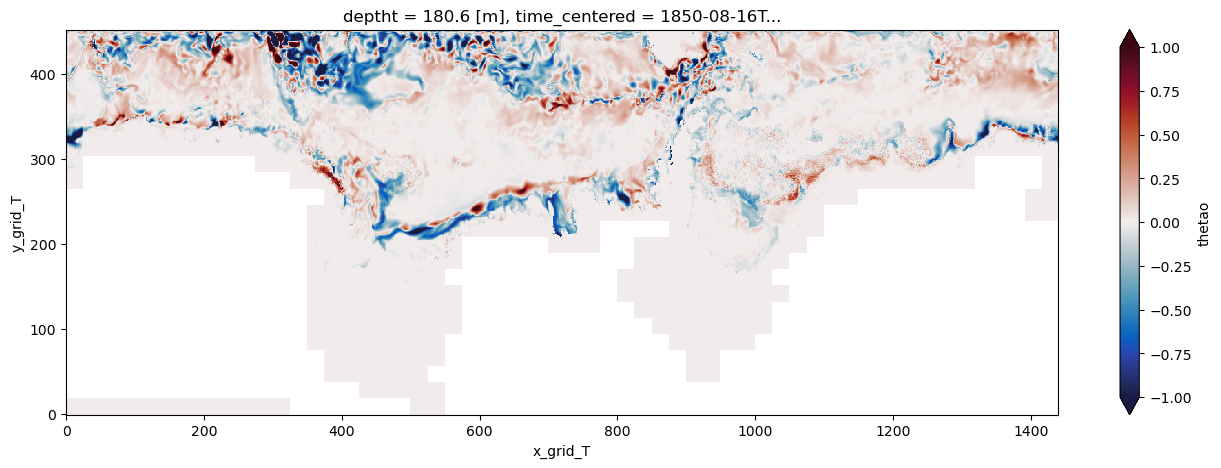

In [23]:
var = 'thetao'
zind=30
(dsT_UBOT[var].isel(time_counter=7, deptht=zind) - dsT_U10[var].isel(time_counter=7, deptht=zind)).plot(figsize=(16,5),
                                                                                                        vmin=-1, vmax=1,
                                                                                                        cmap=cmocean.cm.balance)

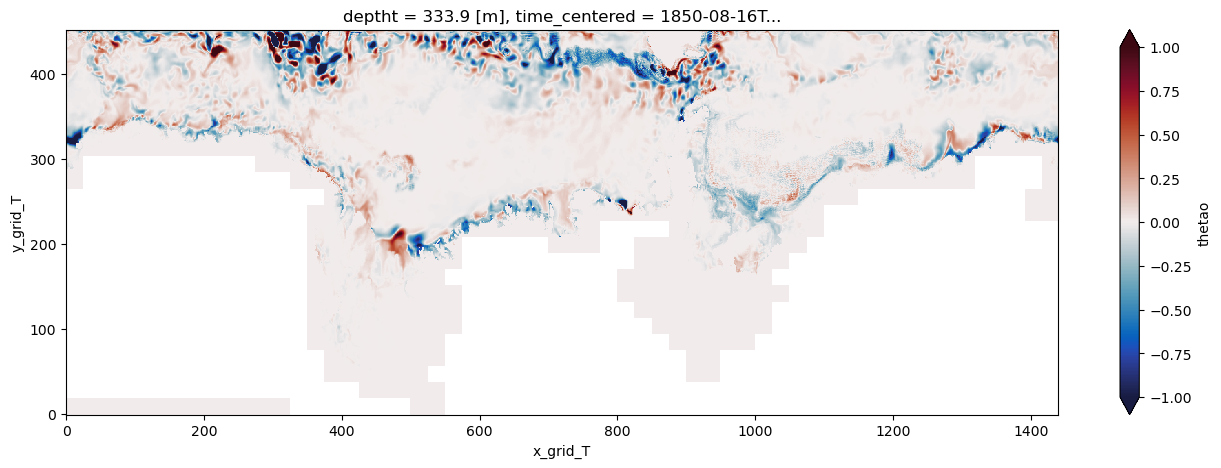

In [21]:
var = 'thetao'
zind=40
(dsT_UBOT[var].isel(time_counter=7, deptht=zind) - dsT_U10[var].isel(time_counter=7, deptht=zind)).plot(figsize=(16,5), 
                                                                                                        vmin=-1, vmax=1,
                                                                                                        cmap=cmocean.cm.balance)

So, using U10, the temperatures at 180 m depth are slightly warmer on the shelf than using UBOT and colder off the shelf. Less export of sea ice would result in a stronger cross shelf gradient and on shelf transport of water